## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import tqdm
from torch.utils.data import Dataset, DataLoader
from utils import *
torch.manual_seed(42)
%matplotlib inline

## Data Paths

In [2]:
try:
    data_path = "E:\\from_cloud\\"
    filenames = [x for x in os.listdir(data_path) if x.endswith(".npy")]
except FileNotFoundError:
    print("Connect external hard drive, stupid.")
    data_path = "C:\\Users\\nikos\\Desktop\\DAS-data\\various-earthquakes\\"
    filenames = [x for x in os.listdir(data_path) if x.endswith(".npy")]


Connect external hard drive, stupid.


### Calculate the global standard deviation of all the data.
1. Read a data file
2. Calculate its standard deviation
3. Append it to a list
4. Repeat for all files
5. Find the average standard deviation
So that I won't run it again, average standard deviation is:
- 2016.0481921881192 for path: C:\Users\nikos\Desktop\DAS-data\various-earthquakes\
- 1414.9583712869814 for path: E:\from_cloud\

Code Used:
```
print(f"Data folder is: {data_path}")
st_devs = []
for x in filenames:
    d = np.load(f"{data_path}{x}",allow_pickle=True)
    st_devs.append(d.std())
print(f"The average standard deviation of the above data folder is: {np.mean(st_devs)}")

```



## PyTorch Dataset

In [3]:
class DAS_Dataset(Dataset):
    """Distributed Acoustic Sensing dataset."""

    def __init__(self, data_path,
                f_min, f_max,N_sub, channel_min = 1700, channel_max = 2300, 
                sampleRate=1000,transform=True):
        """
        Args:
        data_path: Path for the folder containing the DAS data.
        f_min: Minimum Frequency for the butterworth filter. Cuts frequencies below that value.
        f_max: Maximum Frequency for the butterworth filter. Cuts frequencies above that value.
        sampleRate: Sampling Rate of the data OR how many samples per second are taken. Default is 1000 (Hz).
        channel_min: channel to start training from.
        channel_max: channell to end training to.
        N_sub: Number of channels per batch

        """
        self.data_path = data_path
        self.filenames = os.listdir(data_path)
        self.f_min = f_min
        self.f_max = f_max
        self.sampleRate = sampleRate
        self.transform = transform
        self.channel_min = channel_min
        self.channel_max = channel_max
        self.N_sub = N_sub

        # mapping 
        self.all_indexes = []
        for file in filenames:
            for row in range(self.channel_max-self.channel_min):
                self.all_indexes.append((file,row))       

    def __getitem__(self, idx):
        file, row = self.all_indexes[idx]
        x = np.load(f"{data_path}{file}", mmap_mode='r')[self.channel_min:self.channel_max]
        low_index = int(row - self.N_sub/2)
        high_index = int(row + self.N_sub/2)

        # Normalization, this causes minimal data leakage
        x = x/x.std()
        # Copy because assigning values to slices messes things up
        y_ = x[row].copy()
        # x_ = x.copy()
        # Zero out the target channel, the model will predict this.
        x[row] = 0
        
        # if target is close to zero, then pick range [0, N_sub], target is not centered.
        if int(row - self.N_sub/2) <= 0:
            low_index = 0
            high_index = self.N_sub
        # if target is close to max channel, pick range [Nsub, max_channel], target is not centered again.
        if int(row + self.N_sub/2) >= self.channel_max-self.channel_min:
            high_index = self.channel_max-self.channel_min
            low_index = (self.channel_max - self.channel_min) - self.N_sub


        x_ = x[low_index:high_index]
        # Keep only frequencies from f_min to f_max.
        if self.transform:
            x_ = taper_filter(x_, self.f_min, self.f_max, self.sampleRate)
            y_ = taper_filter(y_, self.f_min, self.f_max, self.sampleRate)

        # print(self.all_indexes[idx])
        # Necessary types
        new_row = np.where(np.sum(np.abs(x_), axis=1)==0)[0]
        x_ = torch.tensor(x_.astype(np.float32).copy())
        y_ = torch.tensor(y_.astype(np.float32).copy())
        return new_row, x_, y_
    
    def __len__(self):
        return len(self.all_indexes)


## Notes
- τώρα το output στα άκρα των πινάκων, βγάζουν x τα οποία δεν έχουν το ίδιο shape με τα ενδιάμεσα.
    οπότε ή θα τα κόψουμε τελείως επομένως θα μείνουν channels τα οποία δεν θα έχει κάνει predict το δίκτυο,
    ή θα διαλέγουμε ένα channel τελείως randomly και θα διαλέγουμε τότε `N_sub` channels γύρω από αυτό, έστω και ανομοιόμορφα. (μένει υλοποίηση)
- τσεκάρισμα ότι ο dataloader βγάζει σωστά types (κάποια στιγμή έβγαλε: `TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>`, δεν ξέρω πως.)
- Υλοποίηση Δικτύου, U-Net. Προσοχή εκεί που ενώνεται το residual connection με το υπόλοιπο δίκτυο να έχουν ίδιες διαστάσεις. 

## Model
PyTorch Conv2d Dimensions:
$$H_{o u t}=\left[\frac{H_{i n}+2 \times padding[0]-dilation[0] \times( kernel\_size [0]-1)-1}{stride [0]}+1\right]$$
$$W_{out }=\left[\frac{W_{in }+2 \times padding [1]- dilation [1] \times( kernel\_size [1]-1)-1}{ stride [1]}+1\right]$$


In [4]:
import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

class Down(nn.Module):
    # Contracting Layer
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    # Expanding Layer
    
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x1, x2):
        
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        
        return self.conv(x)


class UNet(nn.Module):
    
    def __init__(self, input_bands = 1, output_classes = 1, hidden_channels=2):
        super(UNet, self).__init__()
        
        # Initial Convolution Layer
        self.inc = nn.Sequential(
            nn.Conv2d(input_bands, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True))
        
        # Contracting Path
        self.down1 = Down(hidden_channels, 2*hidden_channels)
        self.down2 = Down(2*hidden_channels, 4*hidden_channels)
        self.down3 = Down(4*hidden_channels, 8*hidden_channels)
        self.down4 = Down(8*hidden_channels, 8*hidden_channels)
        
        # Expanding Path
        self.up1 = Up(16*hidden_channels, 4*hidden_channels)
        self.up2 = Up(8*hidden_channels, 2*hidden_channels)
        self.up3 = Up(4*hidden_channels, hidden_channels)
        self.up4 = Up(2*hidden_channels, hidden_channels)
        
        # Output Convolution Layer
        self.outc = nn.Conv2d(hidden_channels, output_classes, kernel_size=1)

    def forward(self, x):
        # Initial Convolution Layer
        x1 = self.inc(x)
        
        # Contracting Path
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Expanding Path
        x6 = self.up1(x5, x4)
        x7 = self.up2(x6, x3)
        x8 = self.up3(x7, x2)
        x9 = self.up4(x8, x1)
        # Output Convolution Layer
        logits = self.outc(x9)
        return logits

## GPU 

In [5]:
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device is {device}.')

NVIDIA GeForce RTX 2070
device is cuda:0.


In [6]:
# Instantiate model
model = UNet()
model.to(device)
criterion = nn.MSELoss()
# Optimizer:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# epochs
num_epochs = 2
dataset = DAS_Dataset(data_path, f_min = 1, f_max = 20, N_sub = 32)
data_loader = DataLoader(dataset, shuffle = False, batch_size=20, num_workers=2)

In [13]:
for epoch in range(num_epochs):
    print(f"starting epoch: #{epoch}")
    running_loss = 0.0
    for i, (row,x,y) in tqdm.tqdm(enumerate(data_loader)):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x[None,...])
        loss = criterion(output[0,0,row,:],y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

starting epoch: #0


0it [00:00, ?it/s]C:\Users\nikos\miniconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1, 30000])) that is different to the input size (torch.Size([1, 1, 30000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
2000it [18:13,  1.81it/s]

[1,  2000] loss: 0.001


3394it [30:45,  1.84it/s]


KeyboardInterrupt: 

In [7]:
from time import perf_counter
t1 = perf_counter()
for i, (row,x,y) in tqdm.tqdm(enumerate(data_loader)):
    if i==3:
        break
print(perf_counter()-t1)

## Ένδειξη ότι έχουμε μάθηση (??) μετά από μόνο 3394 single batches.

In [23]:
kala = y.detach().cpu().numpy()
kaka = output.detach().cpu().numpy()

In [52]:
denmasnoiazei = x.detach().cpu().numpy().reshape(32,30000)

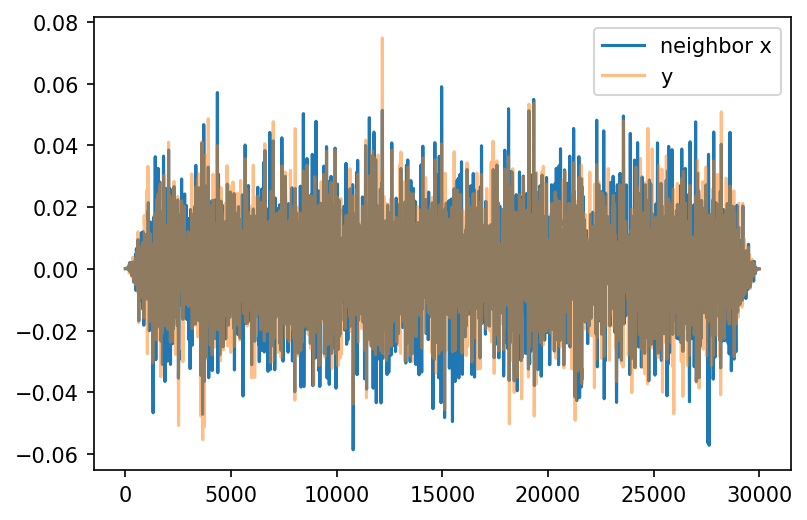

In [60]:
plt.figure(dpi=150)
plt.plot(denmasnoiazei[15], label='neighbor x')
plt.plot(kala[0],alpha=0.5, label='y')
plt.legend()

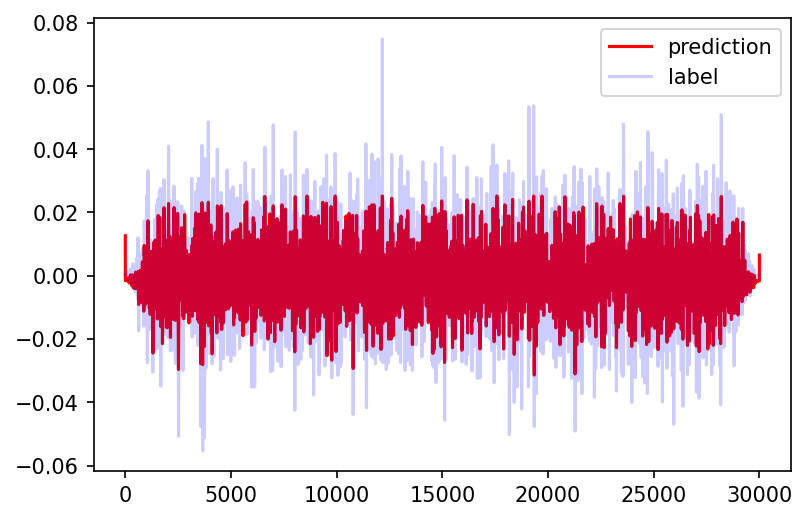

In [47]:
plt.figure(dpi=150)
plt.plot(kaka[0,0,row,:],'r',label='prediction')
plt.plot(kala[0],'b',alpha=0.2, label='label')
plt.legend()

Text(0.5, 1.0, 'input (X) of neighbour channel')

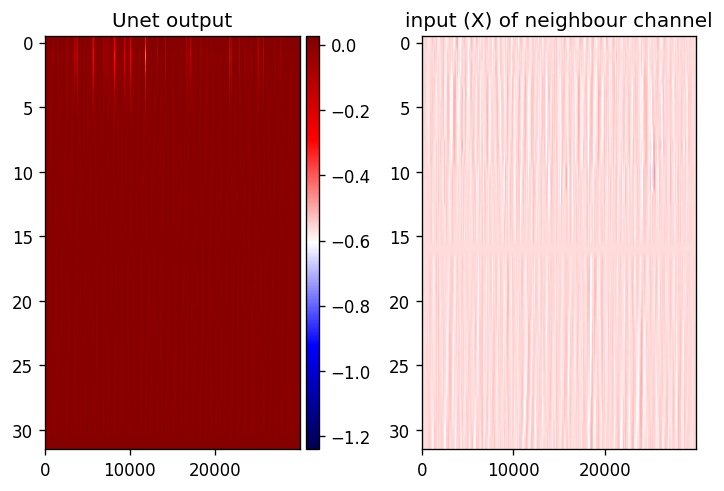

In [80]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1,ax2) = plt.subplots(1,2,dpi=120)
im1 = ax1.imshow(kaka.reshape(32,30000), aspect='auto',cmap = 'seismic')
im2 = ax2.imshow(denmasnoiazei, aspect = 'auto',cmap = 'seismic')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
plt.tight_layout()
ax1.set_title("Unet output")
ax2.set_title("input (X) of neighbour channel")